In [417]:
# numerical calculation & data frames
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

# statistics
import statsmodels.api as sm

In [418]:
booking = pd.read_csv('booking.csv')
booking.head()

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation,booking status
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,10/2/2015,Not_Canceled
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,11/6/2018,Not_Canceled
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2/28/2018,Canceled
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,5/20/2017,Canceled
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,4/11/2018,Canceled


## Category
1. Hotel Cancellation Prediction Model
2. Hotel Average Price Prediction Model

### 1. Hotel Cancellation Prediction Model

##### Data Preprocessing

In [419]:
def clean_data(df):
    df = df.assign(
        year=lambda x: x['date of reservation'].dt.year.astype(str),
        day=lambda x: x['date of reservation'].dt.day.astype(str),
        month=lambda x: x['date of reservation'].dt.month_name().str[:3],
        weekday=lambda x: x['date of reservation'].dt.day_name().str[:3]
    )
    return df

# First, convert 'date of reservation' to datetime, handling invalid dates
booking['date of reservation'] = pd.to_datetime(booking['date of reservation'], errors='coerce')

# Apply the function to the booking DataFrame
hotelbooking = clean_data(booking)

# Displaying the first few rows of the modified DataFrame
hotelbooking.head()
hotelbooking.dropna(inplace=True) # 결측치 제거


In [ ]:
# Change data types
hotelbooking['year'] = hotelbooking['year'].astype(float).astype(int)
hotelbooking['day'] = hotelbooking['day'].astype(float).astype(int)

# Convert month and weekday to categories
hotelbooking['month'] = pd.Categorical(hotelbooking['month'], categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dec'], ordered=True)
hotelbooking['weekday'] = pd.Categorical(hotelbooking['weekday'], categories=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], ordered=True)

# Rename booking status column to cancel
hotelbooking.rename(columns={'booking status':'cancel'}, inplace=True)

# cancel = 1, no cancel = 0
hotelbooking['cancel'].replace(['Canceled', 'Not_Canceled'], [1, 0], inplace=True)

##### Exploratory Data Visualization

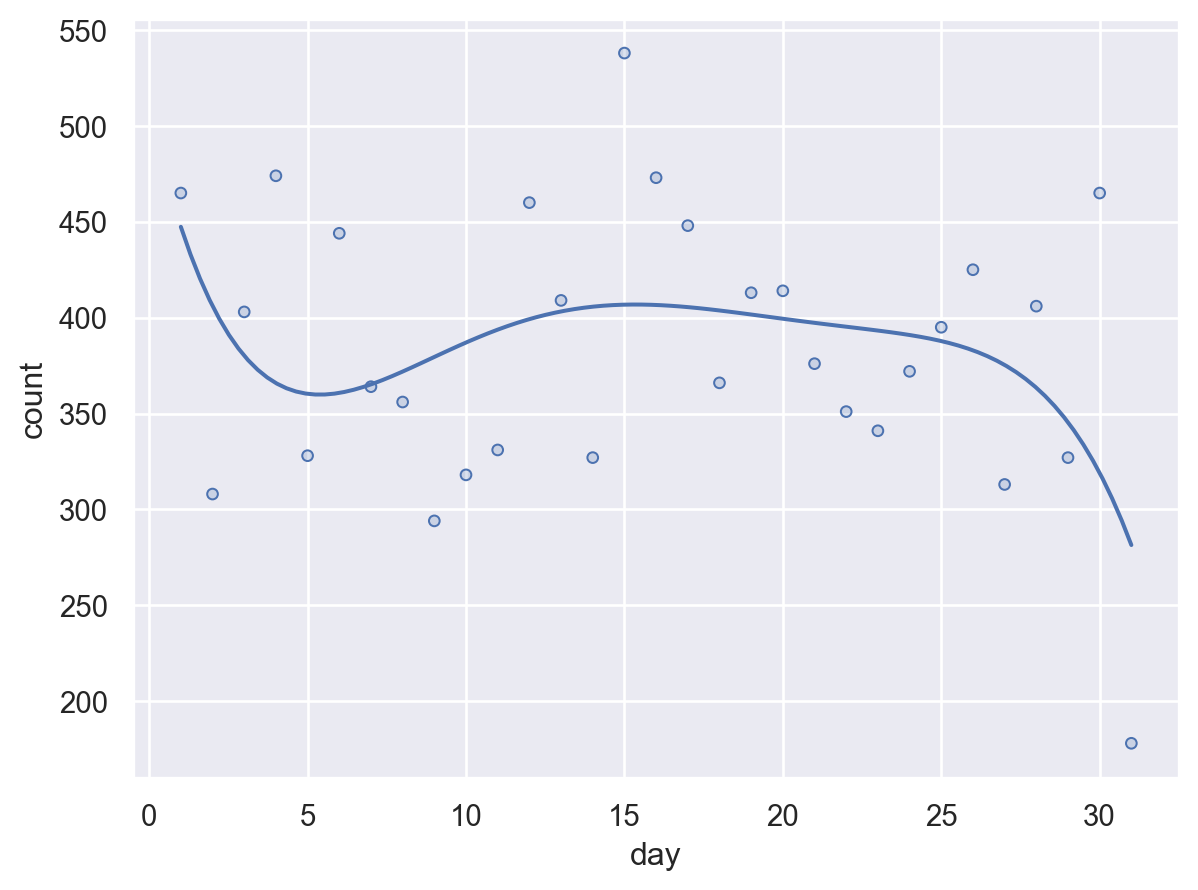

In [ ]:
# Check number of cancellations by day
daycancel = hotelbooking.query('cancel == 1').groupby('day').size().reset_index(name='count')
so.Plot(daycancel, x='day', y='count').add(so.Line(), so.PolyFit(5)).add(so.Dots())

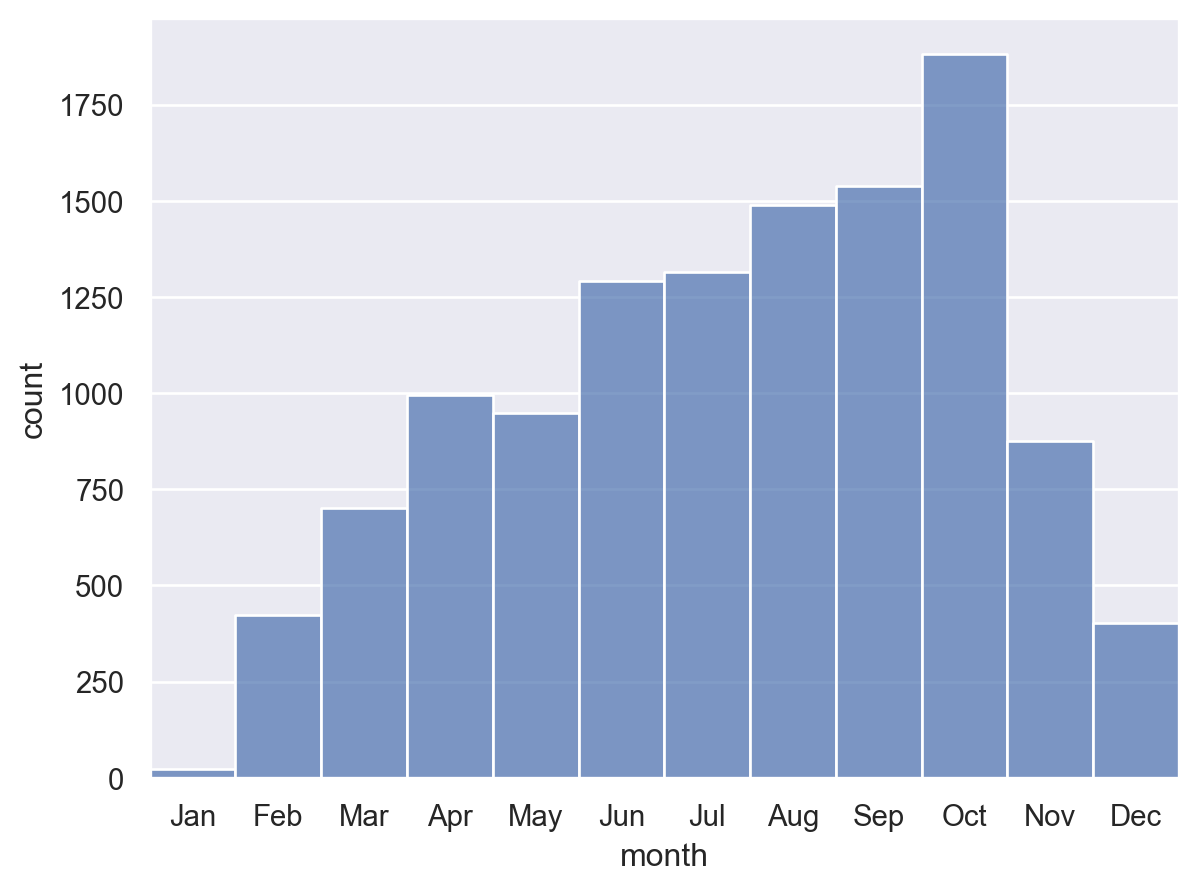

In [ ]:
# Check number of cancellations by month
moncancel = hotelbooking.query('cancel == 1').groupby('month').size().reset_index(name='count')
moncancel
so.Plot(moncancel, x='month', y='count').add(so.Bars())


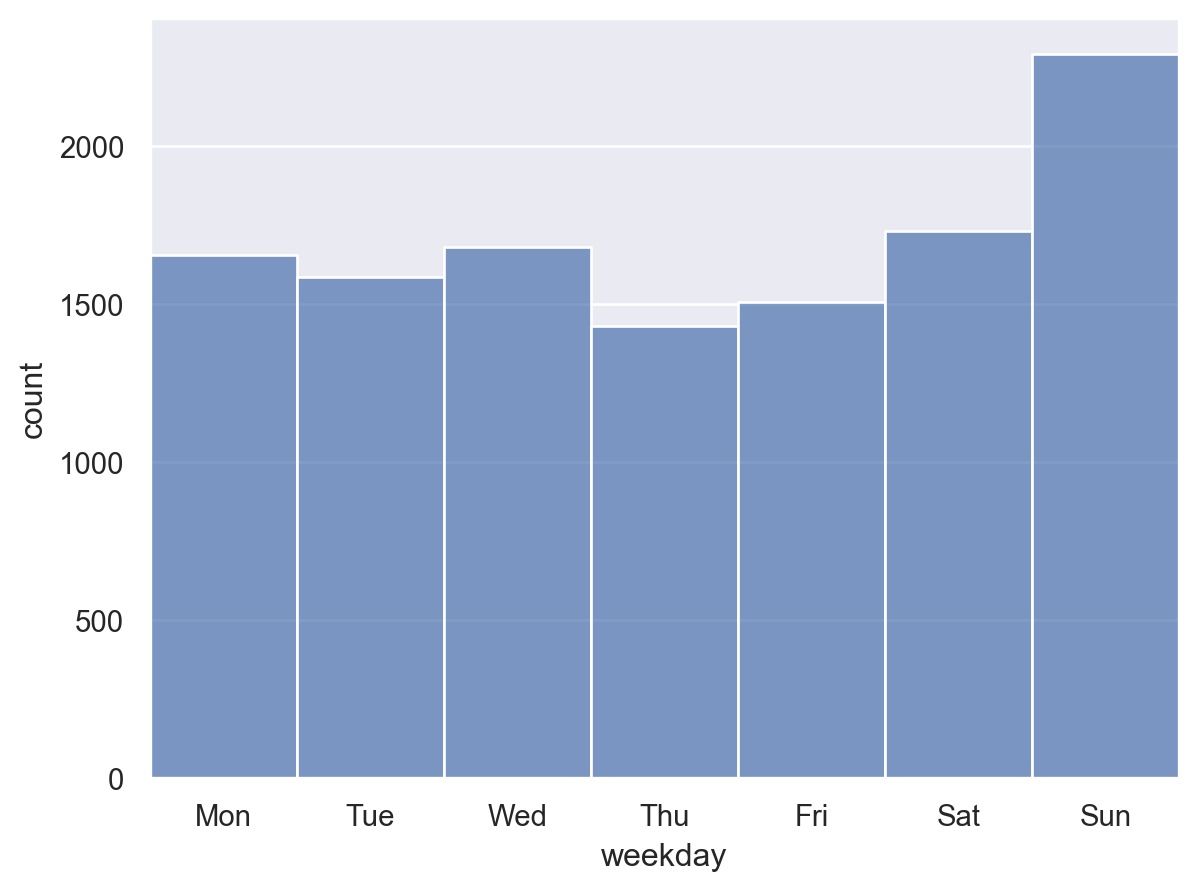

In [ ]:
# Check number of cancellations by weekday
weekcancel = hotelbooking.query('cancel == 1').groupby('weekday').size().reset_index(name='count')
weekcancel  
so.Plot(weekcancel, x='weekday', y='count').add(so.Bars())

In [ ]:
# Convert all other variables to numbers for analysis
# label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
hotelbooking['type of meal'] = le.fit_transform(hotelbooking['type of meal'])
hotelbooking['room type'] = le.fit_transform(hotelbooking['room type'])
hotelbooking['month'] = le.fit_transform(hotelbooking['month'])
hotelbooking['weekday'] = le.fit_transform(hotelbooking['weekday'])

# 불필요한 행 제거(Booking_ID, market segment, car parking space, P-C, P-not C, special request, date of reservation)
# 기준은 분석에 사용할 변수들을 제외한 나머지 변수들
hotelbooking.drop(['Booking_ID', 'market segment type', 'car parking space', 'P-C', 'P-not-C', 'special requests', 'date of reservation'], axis=1, inplace=True)

In [425]:
hotelbooking.head()

,number of adults,number of children,number of weekend nights,number of week nights,type of meal,room type,lead time,repeated,average price,cancel,year,day,month,weekday
0,1,1,2,5,0,0,224,0,88.00,0,2015,2,10,0
1,1,0,1,3,3,0,5,0,106.68,0,2018,6,9,5
2,2,1,1,3,0,0,1,0,50.00,1,2018,28,3,6
3,1,0,0,2,0,0,211,0,100.00,1,2017,20,8,2
4,1,0,1,2,3,0,48,0,77.00,1,2018,11,0,6


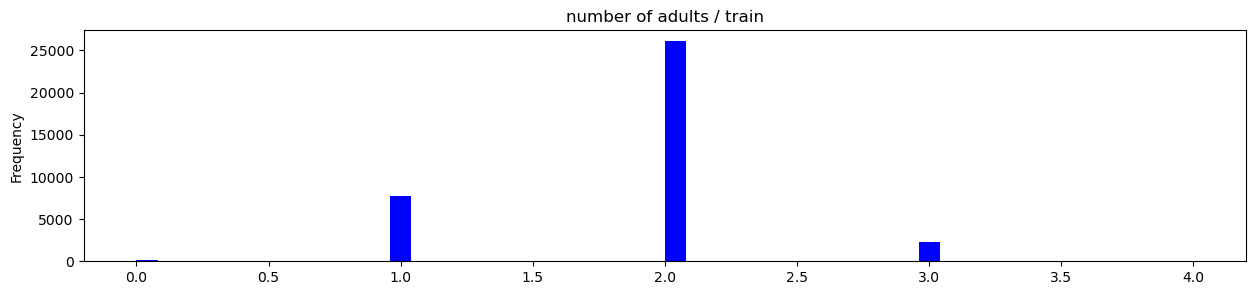

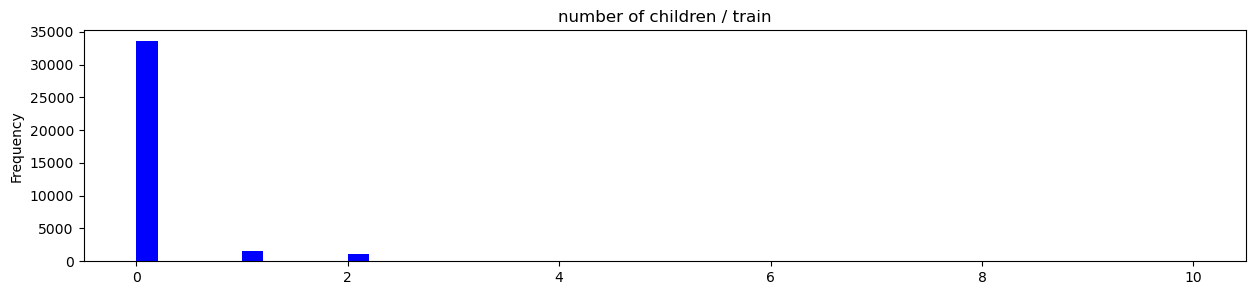

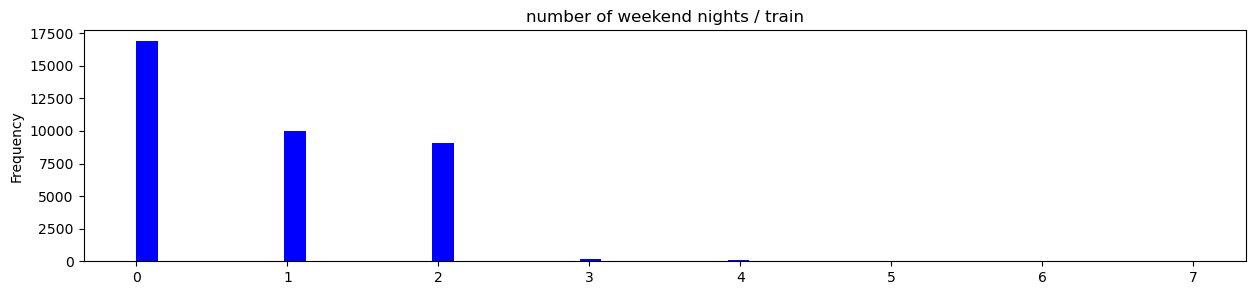

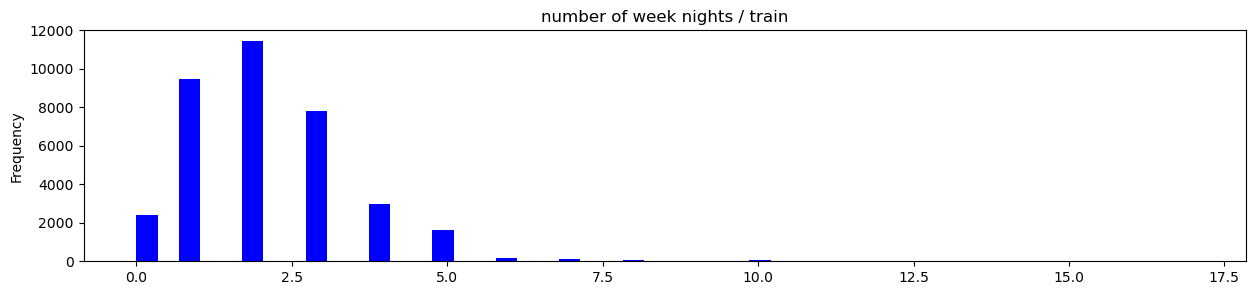

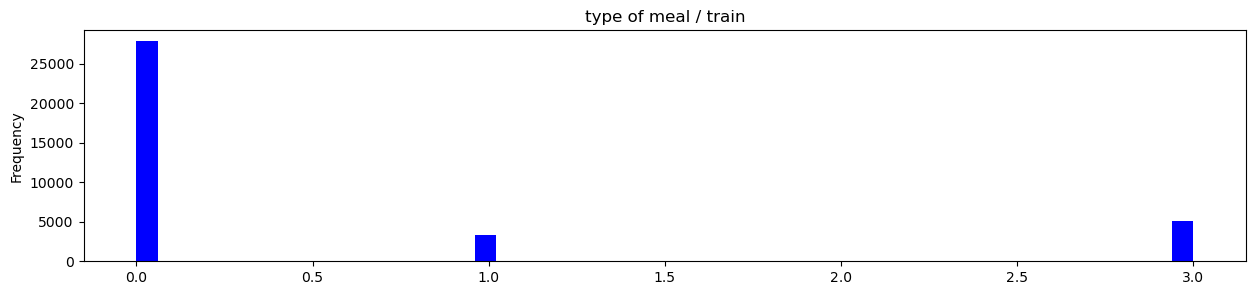

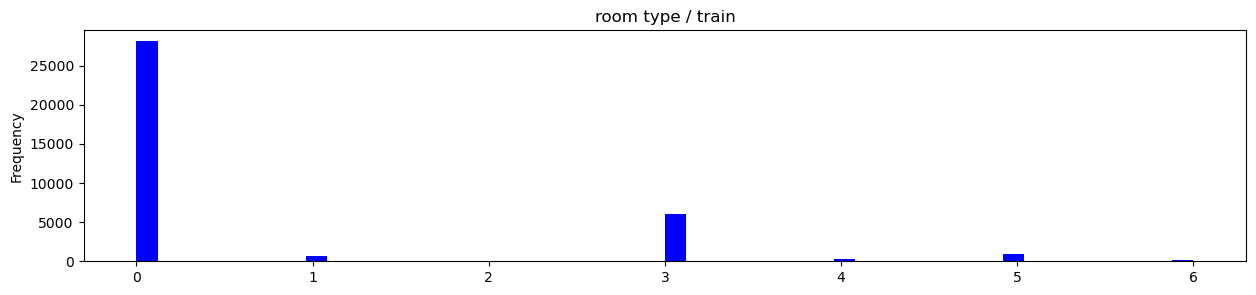

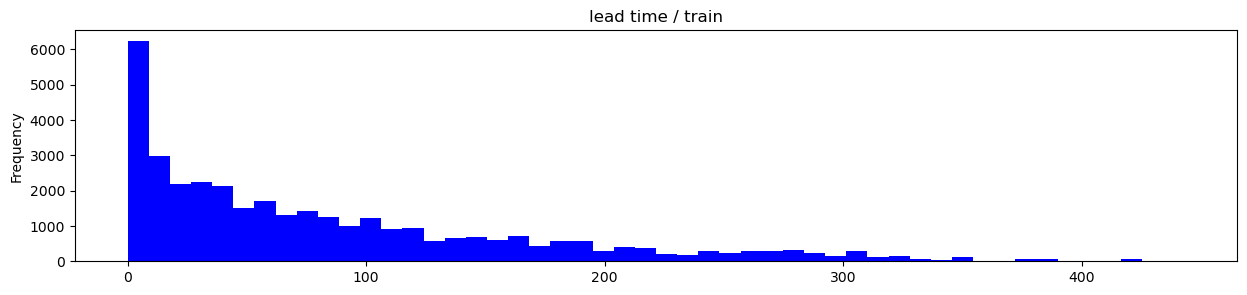

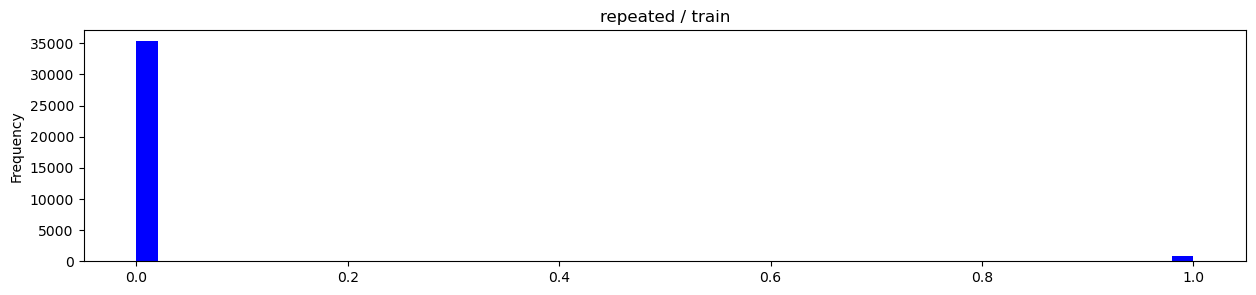

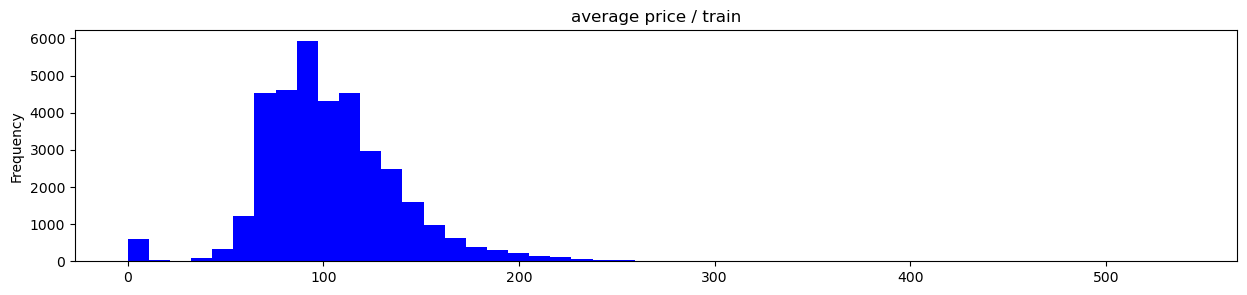

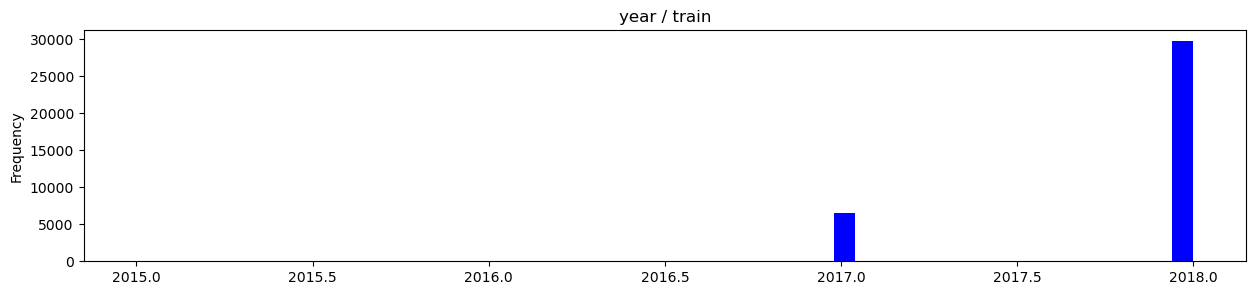

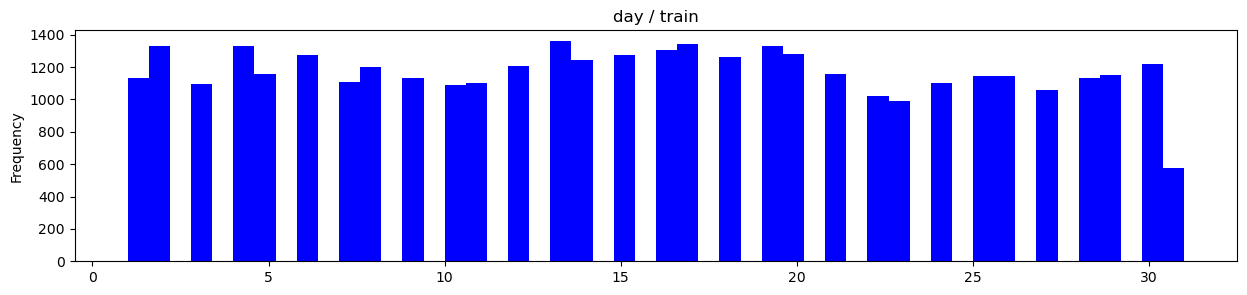

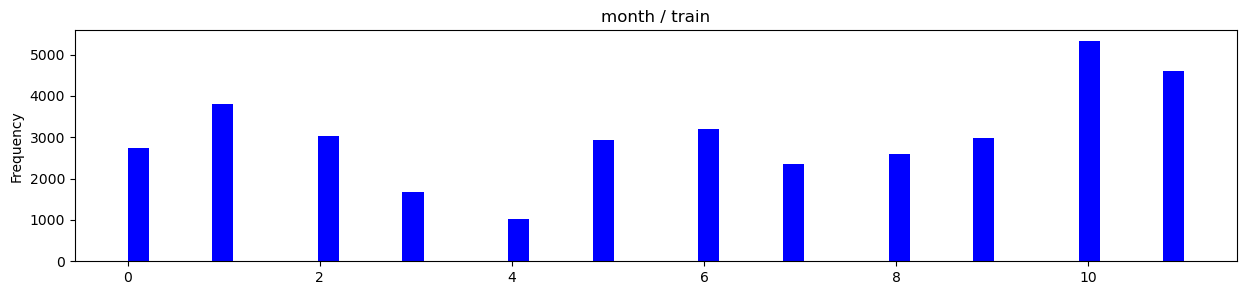

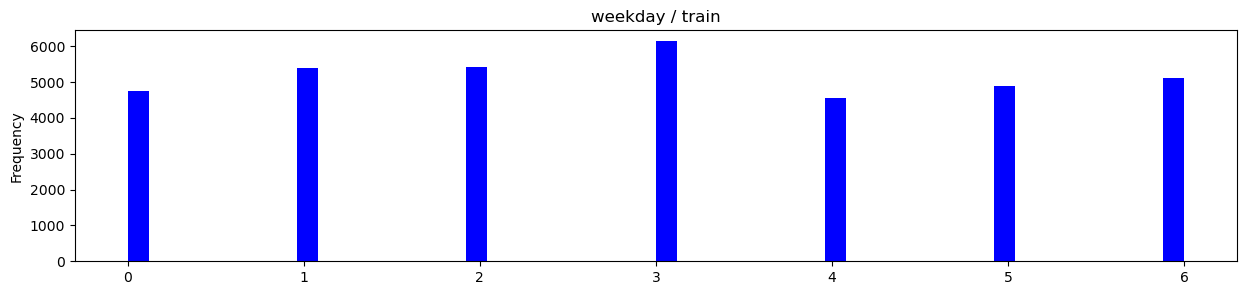

In [ ]:
# Check distribution of each variable
train_feature = hotelbooking.columns.drop('cancel').tolist()

for feat in train_feature:
    plt.figure(figsize=(15,3))
    hotelbooking[feat].plot(kind='hist', bins=50, color='blue')
    plt.title(feat + ' / train')
    plt.show()

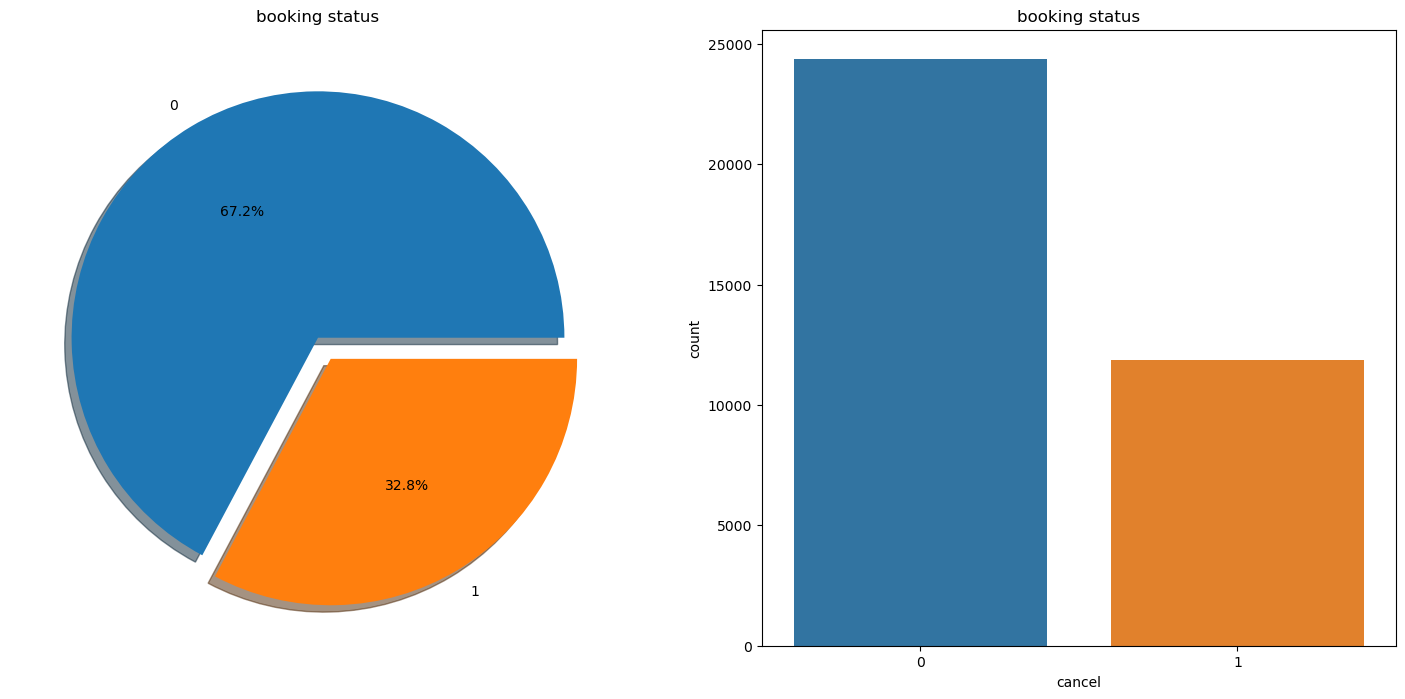

In [ ]:
# Check ratio of hotel cancellations
f,ax=plt.subplots(1,2,figsize=(18,8))
hotelbooking["cancel"].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('booking status')
ax[0].set_ylabel('')
sns.countplot(x = hotelbooking["cancel"],ax=ax[1])
ax[1].set_title('booking status')
plt.show()

# cancel = 1, no cancel = 0

##### Data Modeling

##### Analysis Objective
Predict whether hotel guests will cancel their reservations based on the differences in these variables

1. Use Label Encoding to set all data as categorical
2. Select variables that influence customer cancellation decisions
3. Create three decision models based on these variables:
 - Decision Tree Model
 - Bagging Model
 - Random Forest Model

4. Select the model with highest prediction accuracy among these three models


In [428]:
import numpy as np
from sklearn.datasets import load_wine
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1,
                              random_state=1)
# Split data into 500 pieces and extract features through bootstrap
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500, 
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=1)

rf = RandomForestClassifier(random_state=42,n_estimators=500)


In [430]:
from sklearn.metrics import accuracy_score
X = hotelbooking.drop('cancel', axis=1)
y = hotelbooking['cancel']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                             test_size=0.2, 
                             random_state=1,
                             stratify=y)

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('Bagging train/test accuracies %.3f/%.3f'
      % (bag_train, bag_test))


rf = rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

rf_train = accuracy_score(y_train, y_train_pred) 
rf_test = accuracy_score(y_test, y_test_pred) 
print('RF train/test accuracies %.3f/%.3f'
      % (rf_train, rf_test))
# Random Forest 모델링이 성능이 좋다는 것을 확인 가능

Decision tree train/test accuracies 0.762/0.752


c:\Users\dhjrz\anaconda3\envs\datavis_Evan\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging train/test accuracies 0.762/0.752
RF train/test accuracies 0.990/0.849


### 2. Average Price Prediction Model

##### Data Preprocessing

In [ ]:
# Apply the function to the booking DataFrame
bookingprice = clean_data(booking)
bookingprice.dropna(inplace=True) # Remove missing values


In [ ]:
# Set visualization tools
def boxplot(df, x, y, color=None, alpha=0.1, marker="<"):
    
    return (
        so.Plot(df, x=x, y=y, color=color)
        .add(so.Dots(alpha=alpha, color=".6"), so.Jitter(), so.Dodge())
        .add(so.Range(), so.Est(errorbar=("pi", 50)), so.Dodge())
        .add(so.Dot(pointsize=8, marker=marker), so.Agg("median"), so.Dodge())
        .scale(color="Dark2")
        .theme({**sns.axes_style("whitegrid")})
    )


def rangeplot(df, x, y, color=None, alpha=0.1, marker="<"):

    return (
        so.Plot(df, x=x, y=y, color=color)
        .add(so.Range(), so.Est(errorbar=("pi", 50)), so.Dodge())
        .add(so.Dots(pointsize=8, marker=marker), so.Agg("median"), so.Dodge())
        .scale(color="Dark2")
        .theme({**sns.axes_style("whitegrid")})
    )

In [ ]:
# Change data types
bookingprice['year'] = bookingprice['year'].astype(float).astype(int)
bookingprice['day'] = bookingprice['day'].astype(float).astype(int)

# Convert month and weekday to categories
bookingprice['month'] = pd.Categorical(bookingprice['month'], categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dec'], ordered=True)
bookingprice['weekday'] = pd.Categorical(bookingprice['weekday'], categories=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], ordered=True)

# Create total people column
bookingprice['people'] = bookingprice['number of adults'] + bookingprice['number of children']

# Create total nights column
bookingprice['nights'] = bookingprice['number of weekend nights'] + bookingprice['number of week nights']

# Rename average price column
bookingprice.rename(columns={'average price':'avgprice'}, inplace=True)

# Remove years 2015 and 2016
bookingprice = bookingprice[bookingprice.year != 2015]
bookingprice = bookingprice[bookingprice.year != 2016]

bookingprice.head() 


,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,...,avgprice,special requests,date of reservation,booking status,year,day,month,weekday,people,nights
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,...,106.68,1,2018-11-06,Not_Canceled,2018,6,Nov,Tue,1,4
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,...,50.00,0,2018-02-28,Canceled,2018,28,Feb,Wed,3,4
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,...,100.00,1,2017-05-20,Canceled,2017,20,May,Sat,1,2
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,...,77.00,0,2018-04-11,Canceled,2018,11,Apr,Wed,1,3
6,INN00007,1,1,1,4,Meal Plan 1,0,Room_Type 1,34,Online,...,107.55,1,2017-10-15,Not_Canceled,2017,15,Oct,Sun,2,5


##### Exploratory Data Visualization


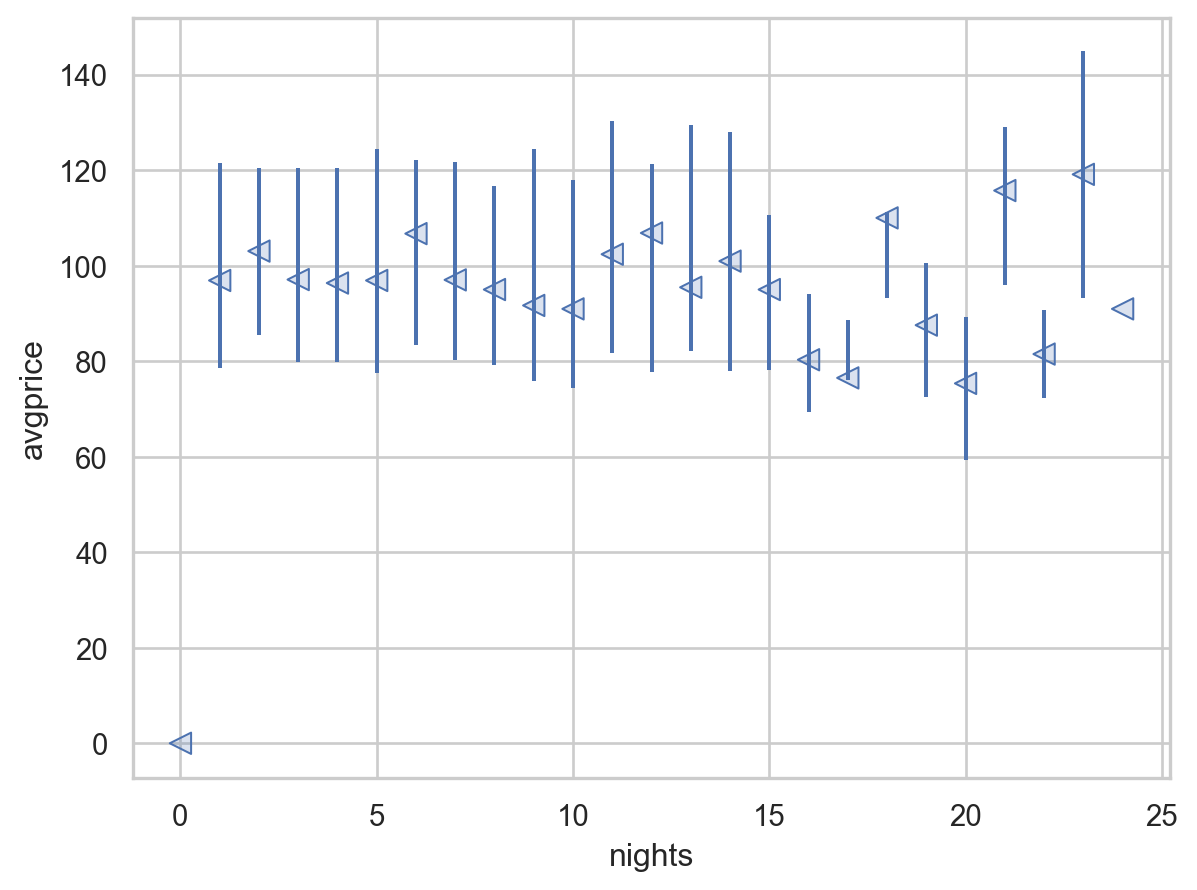

In [434]:
rangeplot(bookingprice, x="nights", y="avgprice")

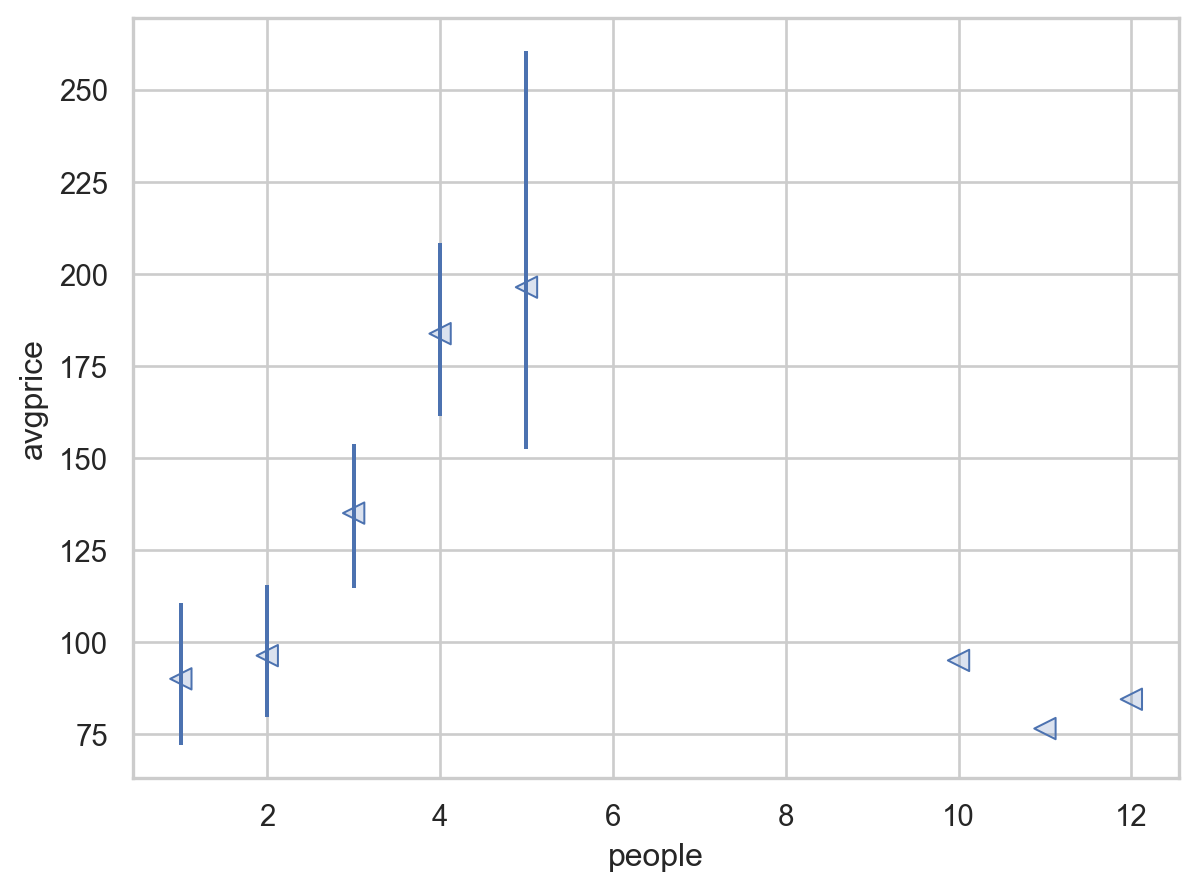

In [435]:
rangeplot(bookingprice, x="people", y="avgprice")

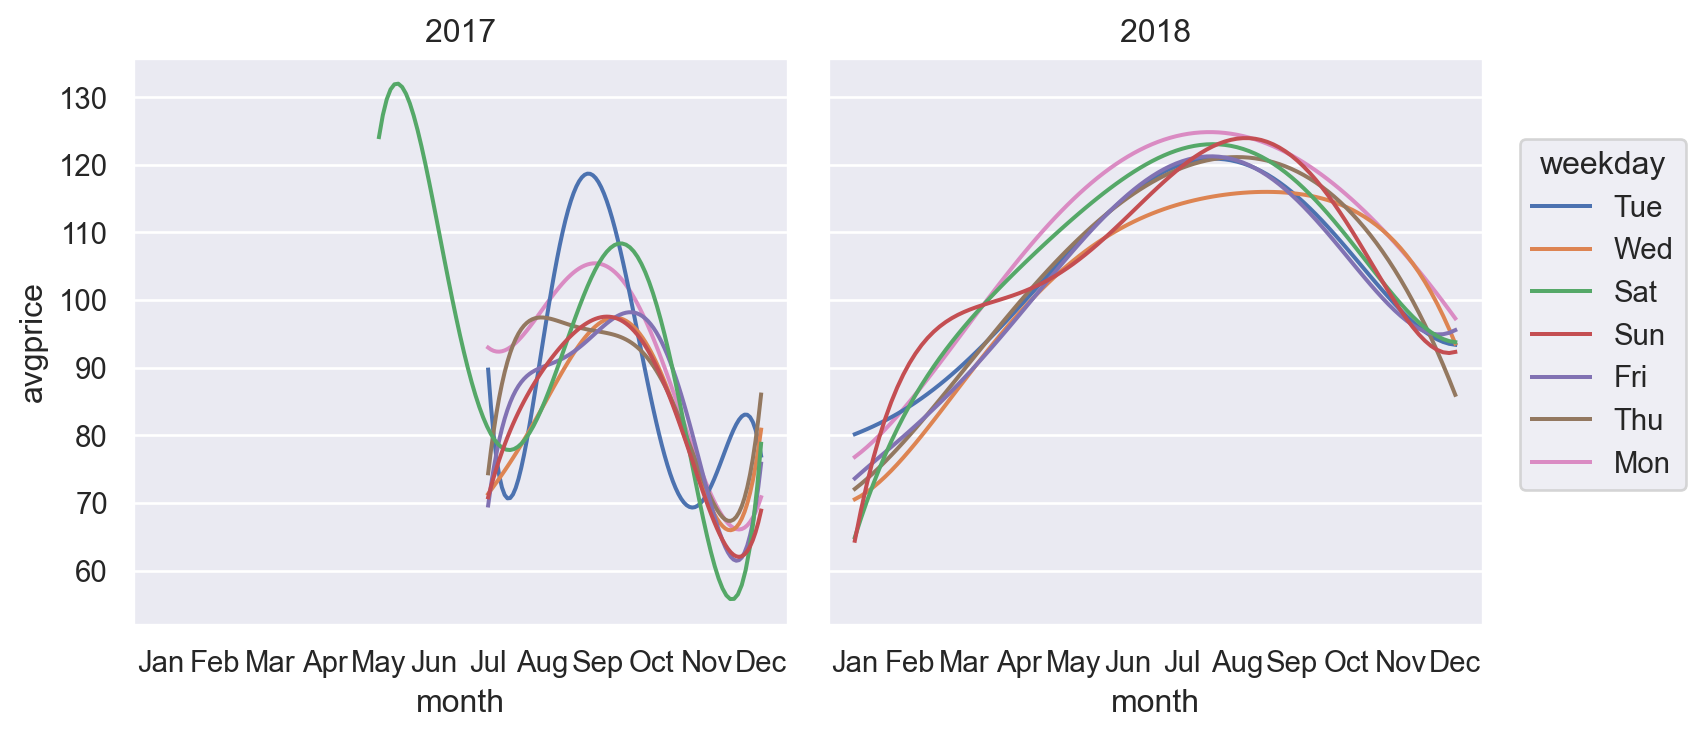

In [ ]:
# Visualize average price by month, day, and weekday
so.Plot(bookingprice, x='month', y='avgprice', color='weekday').add(so.Lines(), so.PolyFit(5)).facet('year').layout(size=(8,4))

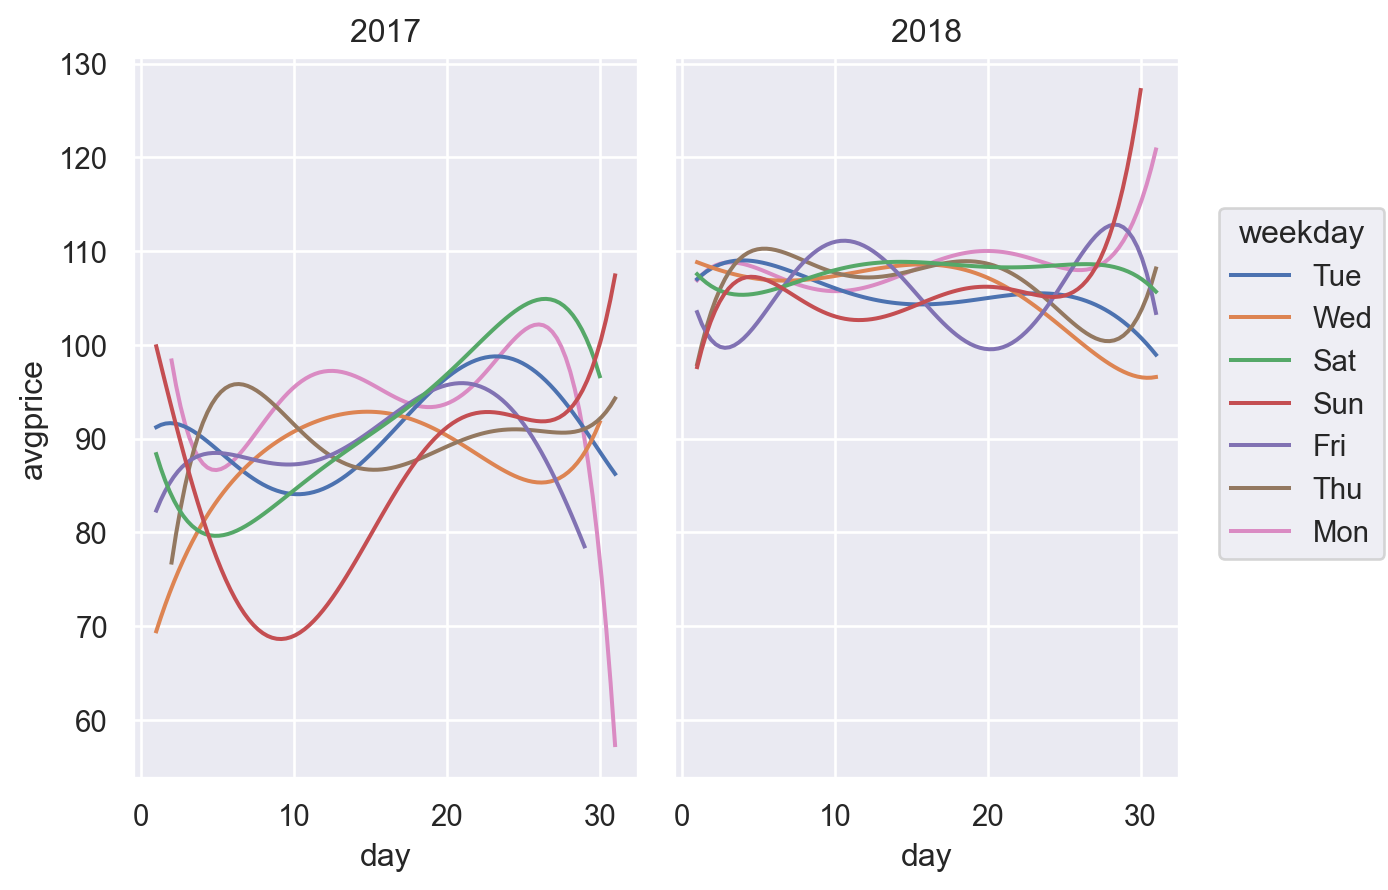

In [437]:
so.Plot(bookingprice, x='day', y='avgprice', color='weekday').add(so.Lines(), so.PolyFit(5)).facet('year')

In [ ]:
bookingprice.query('year == 2017').groupby('month').size().reset_index(name='count')
# Almost no data for January-June 2017

,month,count
0,Jan,0
1,Feb,0
2,Mar,0
3,Apr,0
4,May,1
5,Jun,0
6,Jul,363
7,Aug,1014
8,Sep,1649
9,Oct,1914


##### Data Modeling

In [439]:
import statsmodels.formula.api as smf
mod_r1 = smf.ols("avgprice ~ nights + people + weekday + month", data=bookingprice).fit()

In [440]:
bookingprice_resid = bookingprice.assign(
    resid_m1 = mod_r1.resid,
   )

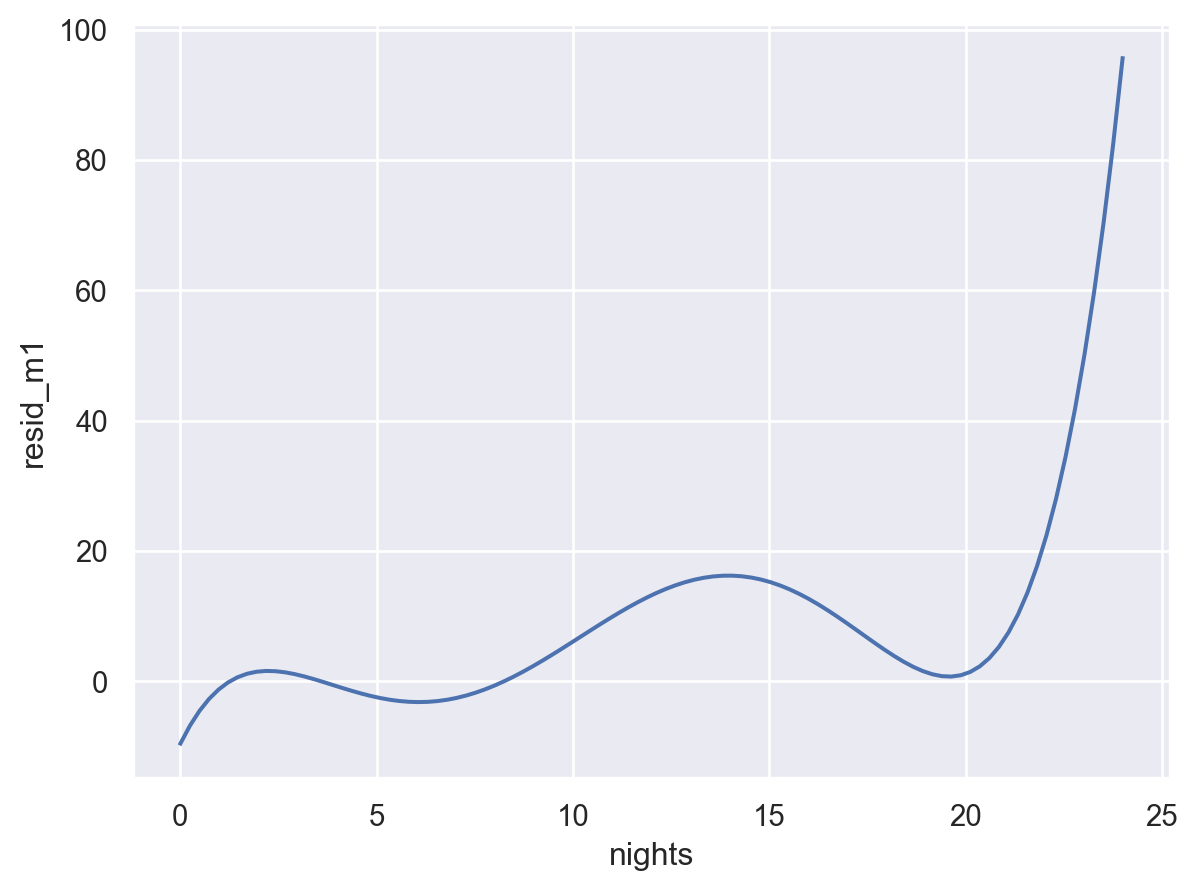

In [441]:
so.Plot(bookingprice_resid, x='nights', y='resid_m1').add(so.Lines(), so.PolyFit(5))

In [442]:
print(mod_r1.rsquared)

0.2946748559896153


In [ ]:
# Include room type and type of meal
# Change data types, label encoding
bookingprice['type of meal'] = le.fit_transform(bookingprice['type of meal'])
bookingprice['room type'] = le.fit_transform(bookingprice['room type'])

# Rename columns
bookingprice.rename(columns={'room type':'roomtype', 'type of meal':'mealtype'}, inplace=True)


In [ ]:
# Modeling
mod_r2 = smf.ols("avgprice ~ nights + people + weekday + month + roomtype + mealtype", data=bookingprice).fit()

In [445]:
bookingprice_resid = bookingprice.assign(
    resid_m2 = mod_r2.resid,
   )


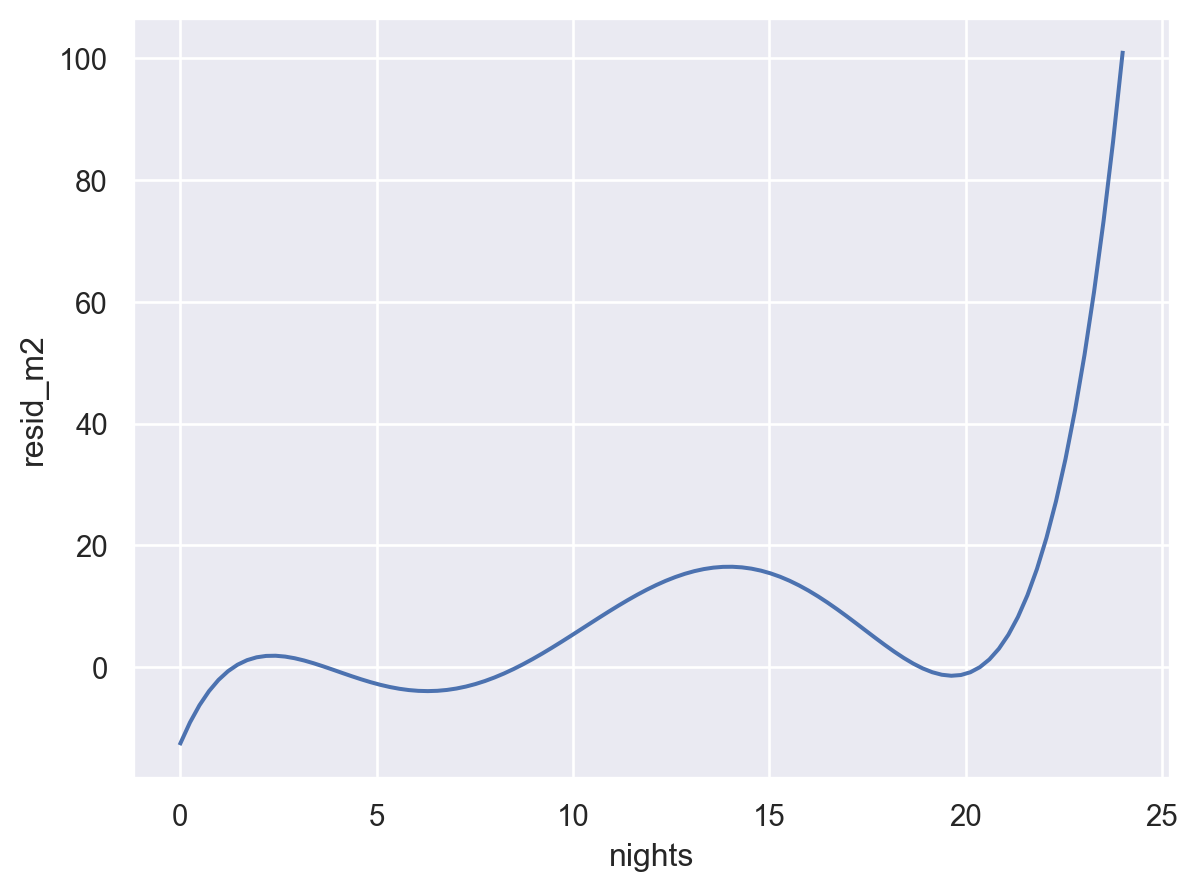

In [446]:
so.Plot(bookingprice_resid, x='nights', y='resid_m2').add(so.Lines(), so.PolyFit(5))

In [447]:
print(mod_r2.rsquared)

0.38425914862962707
